In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [54]:
df = pd.read_csv("insurance_data.csv")


In [55]:
df.head()

,age,gender,bmi,children,smoker,region,premium
0,56,Female,29.7,3,0,east,5459.06
1,69,Male,26.3,2,0,south,6652.66
2,46,Male,20.2,1,0,east,3274.43
3,32,Female,20.2,1,0,east,3604.85
4,60,Male,24.5,4,1,east,9969.13


In [56]:
df.isnull().sum()

age         0
gender      0
bmi         0
children    0
smoker      0
region      0
premium     0
dtype: int64

In [57]:
df['smoker_label'] = df['smoker'].map({0: 'Non-Smoker', 1: 'Smoker'})


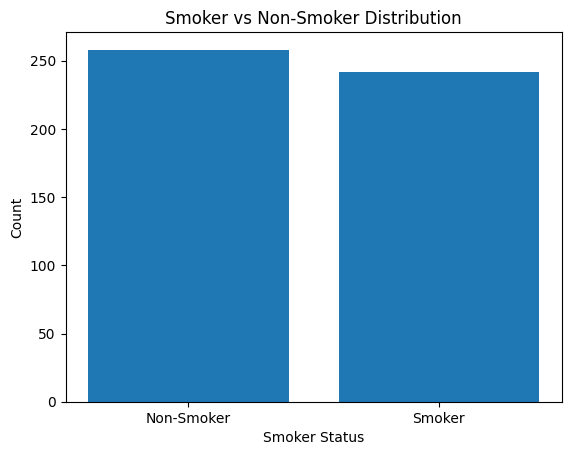

In [58]:
smoker_counts = df['smoker_label'].value_counts()

plt.figure()
plt.bar(smoker_counts.index, smoker_counts.values)
plt.title("Smoker vs Non-Smoker Distribution")
plt.xlabel("Smoker Status")
plt.ylabel("Count")
plt.show()


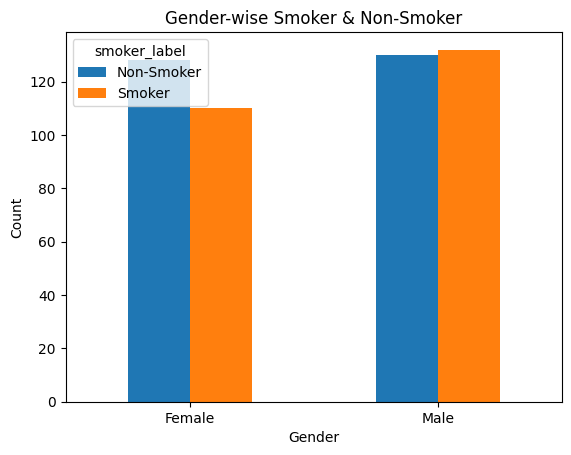

In [59]:
grouped = df.groupby(['gender', 'smoker_label']).size().unstack()

grouped.plot(kind='bar')
plt.title("Gender-wise Smoker & Non-Smoker")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


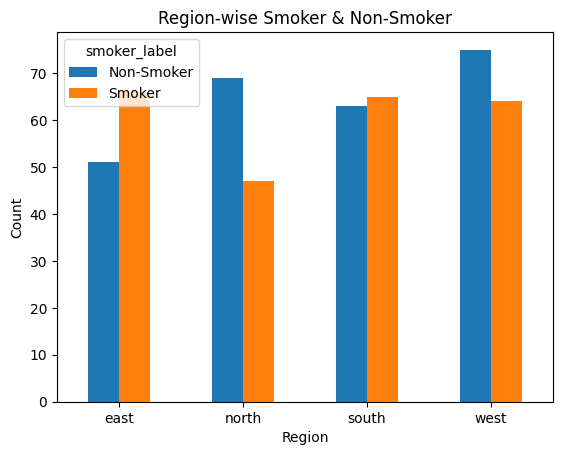

In [60]:
grouped = df.groupby(['region', 'smoker_label']).size().unstack()

grouped.plot(kind='bar')
plt.title("Region-wise Smoker & Non-Smoker")
plt.xlabel("Region")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


In [61]:
data = df.copy()

# Drop visualization column
data.drop(columns=['smoker_label'], inplace=True)


In [62]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [63]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data['gender'] = le.fit_transform(data['gender'])
data['region'] = le.fit_transform(data['region'])


In [64]:
X = data.drop('premium', axis=1)
y = data['premium']


In [65]:
print(X.isnull().sum())
print(y.isnull().sum())


age         0
gender      0
bmi         0
children    0
smoker      0
region      0
dtype: int64
0


In [66]:
X = X.fillna(X.mean())
y = y.fillna(y.mean())


In [67]:
print(X.dtypes)


age           int64
gender        int64
bmi         float64
children      int64
smoker        int64
region        int64
dtype: object


In [68]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [69]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=100,
    random_state=42
)

model.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [70]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_test)

print("MAE :", mean_absolute_error(y_test, y_pred))
print("MSE :", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2  :", r2_score(y_test, y_pred))


MAE : 1055.209206333333
MSE : 2109456.604837188
RMSE: 1452.396848260553
R2  : 0.8133581805103027


In [71]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


In [72]:
rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestR...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'max_depth': [None, 10, ...], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], 'n_estimators': [100, 200]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'r2'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candida

In [73]:
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [74]:
best_model = grid_search.best_estimator_


In [75]:
y_pred = best_model.predict(X_test)

print("R2 Score:", r2_score(y_test, y_pred))


R2 Score: 0.8145664627260779


In [76]:
feature_importance = pd.Series(
    best_model.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

print(feature_importance)


smoker      0.856328
bmi         0.062420
age         0.042988
children    0.026932
region      0.008272
gender      0.003061
dtype: float64


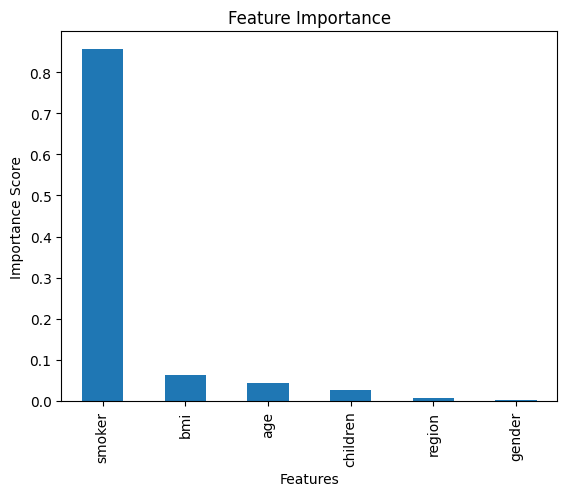

In [77]:
plt.figure()
feature_importance.plot(kind='bar')
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()


In [78]:
def predict_insurance_premium(
        age,
        gender,
        bmi,
        children,
        smoker,
        region
):
    """
    gender: male/female
    smoker: 0 = non-smoker, 1 = smoker
    region: northwest/southeast/southwest/northeast
    """

    # Encode gender
    gender_encoded = 1 if gender.lower() == 'male' else 0

    # Encode region (same order as training)
    region_map = {
        'northeast': 0,
        'northwest': 1,
        'southeast': 2,
        'southwest': 3
    }
    region_encoded = region_map[region.lower()]

    input_data = pd.DataFrame([[
        age,
        gender_encoded,
        bmi,
        children,
        smoker,
        region_encoded
    ]], columns=X.columns)

    return best_model.predict(input_data)[0]


In [79]:
predicted_premium = predict_insurance_premium(
    age=35,
    gender='male',
    bmi=28.5,
    children=2,
    smoker=1,
    region='southeast'
)

print("Predicted Insurance Premium:", predicted_premium)


Predicted Insurance Premium: 10180.696671071531


In [84]:
import pickle as pkl

pkl.dump(best_model,open ("insurance_premium_model.pkl","wb"))